In [132]:
import pandas as pd
import numpy as np
from math import log
import matplotlib.pyplot as plt

In [202]:
vocab = []
f = open("hw4_vocab.txt", 'r')
for line in f.readlines():
    vocab.append(line.rstrip())

unigrams = []
f = open("hw4_unigram.txt", 'r')
for line in f.readlines():
    unigrams.append(int(line.rstrip()))

df = pd.DataFrame({"word": vocab, 
                   "unigram_count": unigrams}, 
                  columns=["word", "unigram_count"])

### 4.3 a)

In [203]:
total = df["unigram_count"].sum()
df["unigram_prob"] = df["unigram_count"] / total
df[df["word"].str.startswith("M")]

,word,unigram_count,unigram_prob
53,MILLION,169479,0.002073
68,MORE,139728,0.001709
76,MR.,117873,0.001442
120,MOST,64424,0.000788
121,MARKET,63807,0.000780
125,MAY,59680,0.000730
129,M.,57514,0.000703
130,MANY,56968,0.000697
158,MADE,45777,0.000560
177,MUCH,42076,0.000515


### 4.3 b)

In [204]:
bigram_words = []
bigram_counts = []
f = open("hw4_bigram.txt", 'r')
for line in f.readlines():
    data = line.rstrip().split("\t")
    bigram_words.append(str(vocab[int(data[0]) - 1]) + 
                        " " + str(vocab[int(data[1]) - 1]))
    bigram_counts.append(int(data[2]))

df2 = pd.DataFrame({"bigram_words": bigram_words, 
                    "bigram_counts": bigram_counts}, 
                   columns=["bigram_words", "bigram_counts"])
df2["first_word"] = df2["bigram_words"].str.split(" ").str[0]
df2["bigram_prob"] = [row['bigram_counts'] / unigrams[vocab
                    .index(row['first_word'])] for index,row in df2.iterrows()]
df2[df2["bigram_words"].str
    .startswith("THE ")].sort_values(["bigram_prob"], 
                                     ascending = False)[0:10]

,bigram_words,bigram_counts,first_word,bigram_prob
993,THE <UNK>,2371132,THE,0.615020
1058,THE U.,51556,THE,0.013372
1064,THE FIRST,45186,THE,0.011720
1060,THE COMPANY,44949,THE,0.011659
1050,THE NEW,36439,THE,0.009451
1165,THE UNITED,33435,THE,0.008672
1086,THE GOVERNMENT,26230,THE,0.006803
1029,THE NINETEEN,25641,THE,0.006651
1282,THE SAME,24239,THE,0.006287
1014,THE TWO,23752,THE,0.006161


### 4.3 c)

In [207]:
def get_unigram_ll(sentence):
    unigrams = sentence.split(" ")
    product = 1
    for word in unigrams:
        if df[df["word"].str.contains("^" + word + "$")]["unigram_prob"].any():
            product *= df[df["word"].str
                          .contains("^" + word + "$")]["unigram_prob"].values[0]
        else:
            print("'" + word + "'" + " not found in corpus")
            product = 0
    
    print("Unigram Log Likelihood for sentence\n '" + 
          sentence + "': " + str(np.log(product)))
    
def get_bigram_ll(sentence):
    bigrams = [b[0] + " " + b[1] for b in zip(sentence
                                              .split(" ")[:-1], 
                                              sentence.split(" ")[1:])]
    bigrams.insert(0, "<s> " + sentence.split(" ")[0])
    product = 1
    for word in bigrams:
        if df2[df2["bigram_words"].str
               .contains("^" + word + "$")]["bigram_prob"].any():
            product *= df2[df2["bigram_words"].str
                .contains("^" + word + "$")]["bigram_prob"].values[0]
        else:
            print("'" + word + "'" + " not found in corpus")
            product = 0
    
    print("Bigram Log Likelihood for sentence\n '" + 
          sentence + "': " + str(np.log(product)))

sentence = "The stock market fell by one hundred points last week".upper()
get_unigram_ll(sentence)
get_bigram_ll(sentence)

Unigram Log Likelihood for sentence
 'THE STOCK MARKET FELL BY ONE HUNDRED POINTS LAST WEEK': -64.5094403436
Bigram Log Likelihood for sentence
 'THE STOCK MARKET FELL BY ONE HUNDRED POINTS LAST WEEK': -40.9181321338


### Bigram model gives a higher log likelihood.

### 4.3 d)

In [208]:
sentence = "The sixteen officials sold fire insurance".upper()
get_unigram_ll(sentence)
get_bigram_ll(sentence)

Unigram Log Likelihood for sentence
 'THE SIXTEEN OFFICIALS SOLD FIRE INSURANCE': -44.2919344731
'SIXTEEN OFFICIALS' not found in corpus
'SOLD FIRE' not found in corpus
Bigram Log Likelihood for sentence
 'THE SIXTEEN OFFICIALS SOLD FIRE INSURANCE': -inf


/usr/lib/python3.6/site-packages/ipykernel/__main__.py:31: RuntimeWarning: divide by zero encountered in log


### The bigrams "sixteen officials" and "sold fire" were not present 
### in the training corpus. The log likelihood for such bigrams is 
### negative infinity which basically means that' we haven't 
### encountered such pairs in the training set. 

### 4.3 e)

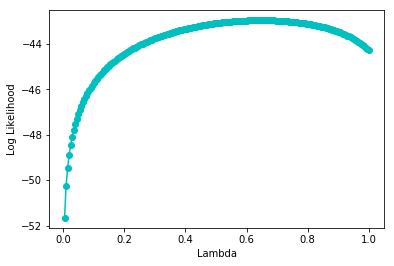

Lambda that maximizes Log Likelihood: 0.6499999999999997
Maximum log-likelihood: -42.964164283


In [214]:
def get_mixture_ll(sentence, lam):
    unigrams = sentence.split(" ")
    bigrams = [b[0] + " " + b[1]  for b in zip(sentence.split(" ")[:-1], 
                                               sentence.split(" ")[1:])]
    bigrams.insert(0, "<s> " + sentence.split(" ")[0])
    product = 1
    for i in range(len(bigrams)):
        if df2[df2["bigram_words"].str
               .contains("^" + bigrams[i] + "$")]["bigram_prob"].any():
            product *= (lam * (df[df["word"].str
                    .contains("^" + unigrams[i] + "$")]["unigram_prob"].values[0]) + 
            (1 - lam) * (df2[df2["bigram_words"].str
                    .contains("^" + bigrams[i] + "$")]["bigram_prob"].values[0]))
        else:
            #print("'" + word + "'" + " not found in corpus")
            product *= lam * (df[df["word"].str
                    .contains("^" + unigrams[i] + "$")]["unigram_prob"].values[0])
    
    return (np.log(product))

lam = 1
mlvalue = []
lams = []
sentence = "The sixteen officials sold fire insurance".upper()
for i in range(200):
    mlvalue.append(get_mixture_ll(sentence, lam))
    lams.append(lam)
    lam = lam - 0.005
    
lams.reverse()
mlvalue.reverse()
plt.plot(lams, mlvalue, color='c', marker='o')
plt.xlabel("Lambda")
plt.ylabel("Log Likelihood")
plt.show()
print("Lambda that maximizes Log Likelihood: " + str(lams[mlvalue.index(max(mlvalue))]))
print("Maximum log-likelihood: " + str(max(mlvalue)))